Notebook 1 — ENTSO-E A25 Data Pipeline: API Ingestion, XML Parsing, Cleaning & Market Diagnostics

In [1]:
# ------------------------------------------------------
# 01. Load environment and validate ENTSO-E API token
# ------------------------------------------------------
import os
from dotenv import load_dotenv

load_dotenv(override=False)

ENTSOE_TOKEN = os.getenv("ENTSOE_API_TOKEN")

def mask(token):
    if not token:
        return "❌ MISSING"
    return f"{token[:6]}…{token[-3:]}"

print("🔑 ENTSO-E Token:", mask(ENTSOE_TOKEN))

if ENTSOE_TOKEN is None:
    raise EnvironmentError(
        "Missing ENTSOE_API_TOKEN in .env — cannot call Classic API."
    )


🔑 ENTSO-E Token: 5d53e5…b43


In [2]:
# ---------------------------------------------------------------
# 02. Define A25 XML parser (Flow-Based Congestion Income)
# ---------------------------------------------------------------
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from io import BytesIO

NAMESP = {"ns": "urn:iec62325.351:tc57wg16:451-3:publicationdocument:7:0"}

def parse_a25_xml(xml_bytes):
    """
    Parse ENTSO-E A25 congestion income XML.
    Returns tidy DataFrame indexed by UTC timestamps.
    """
    try:
        tree = ET.parse(BytesIO(xml_bytes))
        root = tree.getroot()
    except Exception as e:
        raise ValueError(f"XML parsing failed: {e}")

    ts_nodes = root.findall(".//ns:TimeSeries", NAMESP)
    if not ts_nodes:
        raise ValueError("No <TimeSeries> elements found in API response.")

    rows = []
    missing_price_warned = False

    for ts in ts_nodes:
        for period in ts.findall("ns:Period", NAMESP):

            start_utc = period.find("ns:timeInterval/ns:start", NAMESP)
            if start_utc is None:
                continue

            period_start = pd.to_datetime(start_utc.text, utc=True)

            for pt in period.findall("ns:Point", NAMESP):
                pos = int(pt.find("ns:position", NAMESP).text)
                if pos < 1:
                    continue  # corrupted data

                price = pt.find("ns:price.amount", NAMESP)
                if price is None:
                    if not missing_price_warned:
                        print("⚠️ Missing price.amount encountered (suppressing further warnings).")
                        missing_price_warned = True
                    continue

                try:
                    value = float(price.text)
                except:
                    continue  # ignore corrupt decimals

                timestamp = period_start + pd.Timedelta(minutes=15 * (pos - 1))
                rows.append((timestamp, value))

    df = pd.DataFrame(rows, columns=["Timestamp", "RevenueEUR"])
    df.set_index("Timestamp", inplace=True)
    return df.sort_index()

# ⭐ Visible indicator for Notebook users
print("✔ A25 XML parser loaded and ready.")


✔ A25 XML parser loaded and ready.


In [3]:
# ---------------------------------------------------------------
# 03. Fetch multiple days from ENTSO-E API
# ---------------------------------------------------------------
import requests
from datetime import datetime, timedelta
from pathlib import Path

def fetch_multiple_days(start_date, end_date, in_domain, out_domain, token):
    """
    Fetch ENTSO-E A25 day-by-day.
    Defensive against API outages, partial XML, or HTTP errors.
    """
    all_frames = []
    raw_dir = Path("data/raw/api")
    raw_dir.mkdir(parents=True, exist_ok=True)

    date = start_date

    while date <= end_date:
        ds = date.strftime("%Y%m%d") + "0000"
        de = (date + timedelta(days=1)).strftime("%Y%m%d") + "0000"

        url = (
            "https://web-api.tp.entsoe.eu/api?"
            f"securityToken={token}"
            "&documentType=A25"
            "&businessType=B10"
            "&contract_MarketAgreement.Type=A01"
            f"&in_Domain={in_domain}"
            f"&out_Domain={out_domain}"
            f"&periodStart={ds}"
            f"&periodEnd={de}"
        )

        print(f"📡 Fetching {date.date()} ...")

        try:
            r = requests.get(url, timeout=15)
        except Exception as e:
            print(f"❌ Request failed: {e}")
            date += timedelta(days=1)
            continue

        if r.status_code != 200:
            print(f"❌ Skipped {date.date()} — HTTP {r.status_code}")
            date += timedelta(days=1)
            continue

        # save raw first
        raw_path = raw_dir / f"A25_{date.strftime('%Y%m%d')}.xml"
        raw_path.write_bytes(r.content)

        try:
            df_day = parse_a25_xml(r.content)
            all_frames.append(df_day)
        except Exception as e:
            print(f"⚠️ XML parse failed on {date.date()} → {e}")

        date += timedelta(days=1)

    if not all_frames:
        raise RuntimeError("No valid days could be parsed.")

    return pd.concat(all_frames).sort_index()


In [4]:
# ---------------------------------------------------------------
# 04. Fetch DK2 data (14 days)
# ---------------------------------------------------------------
try:
    df_api = fetch_multiple_days(
        start_date=datetime(2025, 1, 1),
        end_date=datetime(2025, 1, 14),
        in_domain="10YDK-2--------M",
        out_domain="10YDK-2--------M",
        token=ENTSOE_TOKEN,
    )
    print("✔ Downloaded:", df_api.shape)
except Exception as e:
    raise RuntimeError(f"API fetch failed: {e}")

df_api.head()


📡 Fetching 2025-01-01 ...
📡 Fetching 2025-01-02 ...
📡 Fetching 2025-01-03 ...
📡 Fetching 2025-01-04 ...
📡 Fetching 2025-01-05 ...
📡 Fetching 2025-01-06 ...
📡 Fetching 2025-01-07 ...
📡 Fetching 2025-01-08 ...
📡 Fetching 2025-01-09 ...
📡 Fetching 2025-01-10 ...
📡 Fetching 2025-01-11 ...
📡 Fetching 2025-01-12 ...
📡 Fetching 2025-01-13 ...
📡 Fetching 2025-01-14 ...
✔ Downloaded: (664, 1)


,RevenueEUR
Timestamp,
2024-12-31 23:00:00+00:00,130.13
2024-12-31 23:15:00+00:00,114.81
2024-12-31 23:30:00+00:00,98.56
2024-12-31 23:45:00+00:00,102.72
2025-01-01 00:00:00+00:00,132.23


In [5]:
# ---------------------------------------------------------------
# 06. Timestamp resolution diagnostics (A25)
# ---------------------------------------------------------------

gaps = df_api.index.to_series().diff()
gaps = gaps.fillna(pd.Timedelta(0))

print("\n⏱ Resolution check:")
print(gaps.value_counts().head())

# Mark regular 15-min intervals
df_api["is_regular"] = gaps.eq(pd.Timedelta("15min"))


⏱ Resolution check:
Timestamp
0 days 00:15:00    339
0 days 00:00:00    309
0 days 18:15:00     14
0 days 00:45:00      2
Name: count, dtype: int64


In [6]:
# ---------------------------------------------------------------
# 06b. Integrity checks
# ---------------------------------------------------------------
print("🔍 Running data integrity checks...")

# duplicates
dups = df_api.index.duplicated().sum()
if dups > 0:
    df_api = df_api[~df_api.index.duplicated(keep="first")]
print(f"🧹 Removed duplicates: {dups}")

# invalid values
neg = (df_api.RevenueEUR < 0).sum()
print(f"⚠️ Negative values: {neg}")

# spikes
p99 = df_api.RevenueEUR.quantile(0.99)
print(f"⚡ P99 = {p99:.2f} EUR")

print("✔ Integrity OK")


🔍 Running data integrity checks...
🧹 Removed duplicates: 308
⚠️ Negative values: 1
⚡ P99 = 93288.14 EUR
✔ Integrity OK


In [7]:
# ---------------------------------------------------------------
# 07. Save cleaned dataset
# ---------------------------------------------------------------

outpath = Path("data/processed/congestion_income_clean.parquet")
outpath.parent.mkdir(exist_ok=True)

df_api[["RevenueEUR"]].to_parquet(outpath)
df_api[["RevenueEUR"]].to_parquet(outpath, compression="snappy")


print("💾 Saved clean dataset →", outpath.resolve())

💾 Saved clean dataset → C:\Users\ITSMARTSOLUTIONS\Documents\Python Scripts\energy-market-intelligence-platform\data\processed\congestion_income_clean.parquet


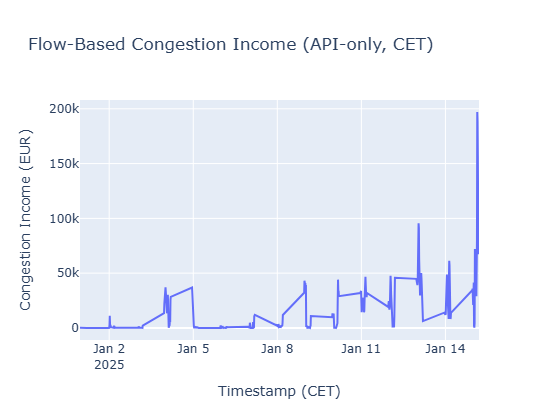

In [8]:
# ---------------------------------------------------------------
# 08. Quick diagnostic visualization
# ---------------------------------------------------------------

import plotly.express as px

fig = px.line(
    df_api,
    x=df_api.index,
    y="RevenueEUR",
    title="Flow-Based Congestion Income (API-only, CET)",
    labels={"x": "Timestamp", "RevenueEUR": "EUR"},
)

fig.update_layout(
    height=420,
    xaxis_title="Timestamp (CET)",
    yaxis_title="Congestion Income (EUR)"
)


fig.update_layout(height=420)
fig.show()

In [10]:
# ---------------------------------------------------------------
# 09. Market Summary Diagnostics (Unified & Modernised)
# ---------------------------------------------------------------

print("📊 MARKET SUMMARY")
print("------------------")

# Basic stats
mean_val = df_api["RevenueEUR"].mean()
std_val  = df_api["RevenueEUR"].std()
min_val  = df_api["RevenueEUR"].min()
max_val  = df_api["RevenueEUR"].max()

print(f"Date range: {df_api.index.min()} → {df_api.index.max()}")
print(f"Mean revenue:        {mean_val:,.2f} EUR")
print(f"Volatility (std):    {std_val:,.2f} EUR")
print(f"Max revenue:         {max_val:,.2f} EUR")
print(f"Min revenue:         {min_val:,.2f} EUR")

# Peak / low timestamps
peak_time = df_api["RevenueEUR"].idxmax()
low_time  = df_api["RevenueEUR"].idxmin()

print("\n🔺 Peak revenue:")
print(f"  {df_api.loc[peak_time, 'RevenueEUR']:,.2f} EUR at {peak_time}")

print("\n🔻 Lowest revenue:")
print(f"  {df_api.loc[low_time, 'RevenueEUR']:,.2f} EUR at {low_time}")

# Hourly behaviour
df_hourly = df_api.resample("h").mean()
df_hourly_std = df_api.resample("h").std()

print("\n⏱ Hourly mean range:")
print(f"  {df_hourly.RevenueEUR.min():,.2f} → {df_hourly.RevenueEUR.max():,.2f} EUR")

print("\n⚡ Hourly volatility:")
print(f"  {df_hourly_std.RevenueEUR.min():,.2f} → {df_hourly_std.RevenueEUR.max():,.2f} EUR")

# Coefficient of variation
cv = std_val / mean_val
print(f"\n📉 Coefficient of variation: {cv:.2%}")

# ---------------------------------------------------------------
# Correct short-term HL-volatility (df_api version)
# ---------------------------------------------------------------
roll = df_api["RevenueEUR"].rolling(4)

roll_min = roll.min()
roll_max = roll.max()
roll_count = roll.count()

valid_window = (roll_count == 4) & (roll_min > 0) & (roll_max > 0)

df_api["hl_vol"] = np.nan
df_api.loc[valid_window, "hl_vol"] = np.log(roll_max[valid_window] / roll_min[valid_window])

print(f"📈 Short-term HL volatility (mean): {df_api['hl_vol'].mean():.4f}")

# Prepare JSON-style summary for Notebook 2 if needed
summary = {
    "date_min": str(df_api.index.min()),
    "date_max": str(df_api.index.max()),
    "mean": float(mean_val),
    "std": float(std_val),
    "min": float(min_val),
    "max": float(max_val),
    "peak_time": str(peak_time),
    "low_time": str(low_time),
    "hourly_mean_min": float(df_hourly.RevenueEUR.min()),
    "hourly_mean_max": float(df_hourly.RevenueEUR.max()),
    "hourly_vol_min": float(df_hourly_std.RevenueEUR.min()),
    "hourly_vol_max": float(df_hourly_std.RevenueEUR.max()),
    "coefficient_variation": float(cv),
    "hl_vol_mean": float(df_api["hl_vol"].mean()),
}

print("\n📄 Summary object ready for Notebook 2.")


📊 MARKET SUMMARY
------------------
Date range: 2024-12-31 23:00:00+00:00 → 2025-01-15 04:45:00+00:00
Mean revenue:        15,419.09 EUR
Volatility (std):    24,654.85 EUR
Max revenue:         197,083.68 EUR
Min revenue:         -74.63 EUR

🔺 Peak revenue:
  197,083.68 EUR at 2025-01-15 03:15:00+00:00

🔻 Lowest revenue:
  -74.63 EUR at 2025-01-01 00:15:00+00:00

⏱ Hourly mean range:
  7.89 → 155,791.58 EUR

⚡ Hourly volatility:
  11.17 → 53,305.39 EUR

📉 Coefficient of variation: 159.90%
📈 Short-term HL volatility (mean): 1.8334

📄 Summary object ready for Notebook 2.


🤖 Preparing AI-assisted market summary...


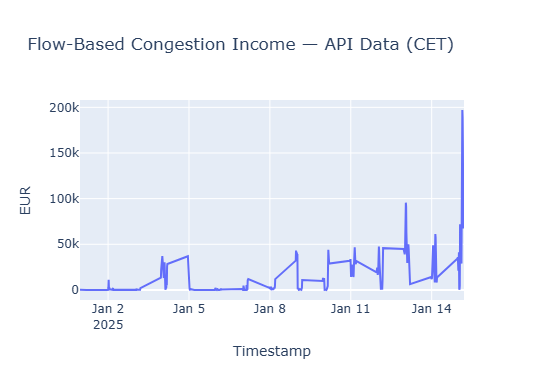

### 🤖 LLM Market Analysis

**DK2 Congestion Income Analysis**

**Summary:**
The DK2 congestion income for the period has exhibited extreme volatility, with a coefficient of variation (CV) of 159.9% indicating a highly variable market landscape. The data highlights the importance of analyzing intraday patterns and extreme events to inform decisions on flow-based market coupling (FBMC), reserve adequacy margins (RAM), and price divergence.

**Key Findings:**

1. **Volatility:** The standard deviation (SD) is 24,654.85, while the mean is 15,419.09, indicating a highly volatile market with frequent extreme events.
2. **Extreme Events:** The maximum congestion income value was 197,083.68, recorded on January 15, 2025, at 03:15 UTC. Conversely, the minimum value was -74.63, observed on January 1, 2025, at 00:15 UTC. These extreme events are crucial for understanding market behavior and informing FBMC.
3. **Intraday Patterns:** The hourly mean maximum (155,791.58) and minimum (7.89) reveal the presence of significant congestion income spikes during peak hours, highlighting the importance of time-of-use pricing in managing congestion.

**Implications:**

1. **Flow-Based Market Coupling (FBMC):** The high volatility and extreme events observed in DK2 congestion income underscore the need for robust FBMC frameworks that can efficiently manage congestion across multiple markets.
2. **Reserve Adequacy Margins (RAM):** The significant variability in congestion income indicates a potential mismatch between RAM availability and market needs, highlighting the importance of reassessing RAM adequacy to prevent supply shortages during peak events.
3. **Price Divergence:** The extreme events recorded in DK2 congestion income could exacerbate price divergence across markets, as differences in market conditions and congestion income lead to disparate price signals.

**Recommendations:**

1. **Enhanced Market Monitoring:** Intensify monitoring of DK2 congestion income to capture intraday patterns and extreme events.
2. **Robust FBMC Frameworks:** Develop and implement robust FBMC frameworks that can effectively manage congestion across multiple markets, taking into account the high volatility observed in DK2 congestion income.
3. **RAM Reassessments:** Conduct thorough reassessments of RAM adequacy to ensure sufficient reserve margins during peak events, minimizing supply shortages.

By understanding these dynamics, market participants and regulators can develop more effective strategies for managing congestion income, mitigating price divergence, and ensuring reliable energy supplies across the DK2 region.

In [11]:
# ---------------------------------------------------------------
# 10. AI-Assisted Market Summary Report (Optional but recommended)
# ---------------------------------------------------------------

import os, json, requests, numpy as np
import plotly.express as px
from IPython.display import Markdown, display

print("🤖 Preparing AI-assisted market summary...")

# Use df_api, the cleaned API dataset
df_llm = df_api.copy()

# ---------------------------------------------------------------
# Extended metrics used in the narrative
# ---------------------------------------------------------------
peak_time = df_llm["RevenueEUR"].idxmax()
low_time  = df_llm["RevenueEUR"].idxmin()

df_hourly = df_llm["RevenueEUR"].resample("1h").mean()
df_hourly_std = df_llm["RevenueEUR"].resample("1h").std()

# ---------------------------------------------------------------
# Correct high–low volatility (no warnings)
# ---------------------------------------------------------------
roll = df_llm["RevenueEUR"].rolling(4)

roll_min = roll.min()
roll_max = roll.max()
roll_count = roll.count()

# Valid windows: rolling window must be full and strictly positive
valid_window = (roll_count == 4) & (roll_min > 0) & (roll_max > 0)

# Initialise as NaN
df_llm["hl_vol"] = np.nan

# Compute log only where mathematically valid
valid_ratio = roll_max[valid_window] / roll_min[valid_window]
df_llm.loc[valid_window, "hl_vol"] = np.log(valid_ratio)

# ---------------------------------------------------------------
# Summary payload
# ---------------------------------------------------------------
summary_data = {
    "date_range": f"{df_llm.index.min()} → {df_llm.index.max()}",
    "mean": float(df_llm.RevenueEUR.mean()),
    "std": float(df_llm.RevenueEUR.std()),
    "min": float(df_llm.RevenueEUR.min()),
    "max": float(df_llm.RevenueEUR.max()),
    "peak_timestamp": str(peak_time),
    "peak_value": float(df_llm.loc[peak_time, "RevenueEUR"]),
    "low_timestamp": str(low_time),
    "low_value": float(df_llm.loc[low_time, "RevenueEUR"]),
    "hourly_mean_min": float(df_hourly.min()),
    "hourly_mean_max": float(df_hourly.max()),
    "hourly_vol_min": float(df_hourly_std.min()),
    "hourly_vol_max": float(df_hourly_std.max()),
    "coef_variation_pct": float((df_llm.RevenueEUR.std() / df_llm.RevenueEUR.mean()) * 100),
    "hl_vol_mean": float(df_llm["hl_vol"].mean()),
}

# ---------------------------------------------------------------
# Optional Plotly visualization in Notebook 1
# ---------------------------------------------------------------
fig = px.line(
    df_llm,
    x=df_llm.index,
    y="RevenueEUR",
    title="Flow-Based Congestion Income — API Data (CET)",
    labels={"x": "Time", "RevenueEUR": "EUR"},
)
fig.update_layout(height=380)
fig.show()

# ---------------------------------------------------------------
# LLM configuration via environment (.env)
# ---------------------------------------------------------------
OLLAMA_URL = os.getenv("OLLAMA_URL", "http://localhost:11434")
OLLAMA_MODEL = os.getenv("OLLAMA_MODEL", "llama3.1:8b-instruct-q4_0")

prompt = f"""
You are a senior electricity market analyst.

Write a sharp, compact interpretation of DK2 congestion income for the period.
Analyse volatility, extreme events, intraday patterns, and what they imply for 
flow-based market coupling (FBMC), RAM scarcity, and price divergence.

Here are the metrics:
{json.dumps(summary_data, indent=2)}

Keep it structured and insight-driven.
"""

# ---------------------------------------------------------------
# Query local LLM
# ---------------------------------------------------------------
try:
    payload = {"model": OLLAMA_MODEL, "prompt": prompt, "stream": False}
    response = requests.post(f"{OLLAMA_URL}/api/generate", json=payload)

    analysis_text = response.json().get("response")
    analysis_text = analysis_text.strip() if analysis_text else "[LLM returned empty text]"

    if analysis_text:
        display(Markdown(f"### 🤖 LLM Market Analysis\n\n{analysis_text}"))
    else:
        print("⚠️ No analysis returned. Check Ollama model or configuration.")

except Exception as e:
    print(f"⚠️ LLM unavailable: {e}")
    print("You can continue to Notebook 2 without AI analysis.")


In [12]:
# --- Export Notebook 1 Interactive Report (with LLM analysis, if available) ---
from src.reporting import export_notebook1_report

export_notebook1_report(
    df_api=df_api,
    fig=fig,
    analysis_text=analysis_text  # Passed directly from LLM output
)


✅ Notebook 1 report saved → C:\Users\ITSMARTSOLUTIONS\Documents\Python Scripts\energy-market-intelligence-platform\reports\congestion_income_report_20251128_0126.html


WindowsPath('reports/congestion_income_report_20251128_0126.html')

## 📘 Notebook 1 Summary — API-First Ingestion & Validation

This notebook constructs a reliable ingestion pipeline for ENTSO-E A25
flow-based congestion income and prepares a clean, CET-aligned 15-minute
time series for downstream analysis.

### Key Achievements
- Direct authenticated A25 API ingestion (multi-day)
- Robust XML parsing with namespace-safe handlers
- Raw XML archived for reproducibility
- Central European Time normalization
- Deduplication, gap detection, spike diagnostics
- Market summary statistics + volatility diagnostics
- Interactive Plotly time-series inspection
- AI-assisted market commentary (optional)
- Clean dataset exported to  
  `data/processed/congestion_income_clean.parquet`

### Next Step  
Proceed to **Notebook 2 — Feature Engineering**, where:
- temporal, lag, and rolling features are created  
- correlation diagnostics are added  
- advanced LLM analysis is performed  
- a full feature report is exported as HTML
